<CENTER> <H1> Blockchain-Cryptocurrency Trading </H1>
<h3>Chunhui Zhu  
James Kuruvilla   
Peter Goodridge<BR>
Publish Date：5/24/2018
</center></H3>

### Initialization

#### Abstract: 

The Cryptocurrency market is a recent addition to the universe of financial markets. One of the defining characteristics of the crypto market is a very high volatility and risk relative to the current nominal currency market. Worldwide, Cryptocurrency regulation faces a challenging situation in its security standard, since blockchain technology varies from country to country. In some regards the market is opaque, as it is very hard to verify where investors are from and what factors are motivating their investments. These dynamics lead to the high volatility seen on the crypto market. 

In our final project, we will have two parts analysis focus on arbitrage opportunity and price perdition. Part one analyst used technical indicators on trading data visualizations to find the opportunity of investment, and the arbitrage method inspired from economic marketing trading. We used historical prices in various time intervals (last 24 hours, 1 weeks, 20 days, 100 days) of the major alto-coin trading (coin pairs) and coin-currency (coin pairs) provide timely analysis for finding possible chance of arbitrage. Second part used stochastic processes and the Black-Scholes model in combination with machine learning methods to predict the cryptocurrency market price, and use our predictions to discover arbitrage opportunities. We used historical prices to train our models. At end, we will analyze those methods we used, documenting their pros and cons, and provide suggestions for future improvements. 

#### Data resources:
1.	https://coinmarketcap.com/coins/
2.	https://bittrex.com/home/api 
3.	https://www.deribit.com/main#/options

In [151]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.ensemble as ske
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from sklearn.metrics import auc, roc_curve, f1_score, make_scorer, r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV,  cross_val_score, KFold
import warnings
import seaborn as sns
import pandas as pd
import time
import numpy as np
import datetime as DT
import requests
import urllib.request as web
import json 
from matplotlib.finance import candlestick2_ohlc
from dateutil.parser import parse
import itertools
import statsmodels.api as sm
plt.style.use('fivethirtyeight')
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
reg=LinearRegression()
from decimal import Decimal
from bs4 import BeautifulSoup

### Part One : Trading Data Visualization

#### Technical Trading for Finance 

We start our analysis from the a single trade, example "USDT-BTC", getting BTC last 100 days trading USD price from Coinmarketcap.com.

In [153]:
def historyprice(com,numdays):   
    #use datatime function to calculate the date before 100 days
    #and store as backdate base on the designed formate
    today=DT.date.today()
    backdate= today-DT.timedelta(days=numdays)
    formate='%Y%m%d'
    backdate=backdate.strftime(formate)
    today=today.strftime(formate)

    #assign today and back100date to url date range
    #https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20180305&end=20180404
    url="https://coinmarketcap.com/currencies/"+com+"/historical-data/?start="+backdate+"&end="+today
    soup = BeautifulSoup(requests.get(url, "lxml").content)
    headings=[th.get_text() for th in soup.find("tr").find_all("th")]
    
    histdata=[]
    for row in soup.find_all("tr")[1:]:
        rowdata = list(td.get_text().replace(",","") for td in row.find_all("td"))
        histdata.append(rowdata)   

    #stor histroy data in a panda df his100
    #Change the type of datetime and order data by date
    hist=pd.DataFrame(histdata,columns=headings)
    hist=hist.convert_objects(convert_numeric=True)
    
    hist['Date'] = [parse(d).strftime('%Y-%m-%d') for d in hist['Date']]
    hist=hist.sort_values(by='Date')
    hist.columns = ['Date', 'Open','High','Low','Close','Volume','MarketCap']
    #hist.index = hist.Date
    return(hist)

hist = historyprice("bitcoin",100)
hist.tail()

,Date,Open,High,Low,Close,Volume,MarketCap
4,2018-05-20,8246.99,8562.41,8205.24,8513.25,5191060000,140556000000
3,2018-05-21,8522.33,8557.52,8365.12,8418.99,5154990000,145264000000
2,2018-05-22,8419.87,8423.25,8004.58,8041.78,5137010000,143534000000
1,2018-05-23,8037.08,8054.66,7507.88,7557.82,6491120000,137024000000
0,2018-05-24,7561.12,7738.60,7331.14,7587.34,6049220000,128925000000


We created CCI, SMA, ESMA and ROC technical indicators on last 100 historical closing prices to find the opportunity of investment. For SAM, we used 7 days rolling mean. For ESMA, we use 20 days rolling mean.

Analysis:

Simple Moving Average (SMA):is an arithmetic moving average calculated by adding the closing price of the security for a number of time periods and then dividing this total by the number of time periods. Short-term averages can act as levels of support when the price experiences a pullback.

Exponentially-weighted Moving Average (EWMA): weights samples in geometrically decreasing order so that the most recent samples are weighted most highly while the most distant samples contribute very little.

Volume Change: is measure the relative worth of a market move, and checking the positive and negative signs for getting in and out of the market.

Commodity Channel Index (CCI): can be used to determine overbought and oversold levels. Readings above +100 can imply an overbought condition, while readings below −100 can imply an oversold condition.

The Rate of Change (ROC): is to measures the percentage change between the most recent price and the price 7 days ago. The indicator fluctuates around the zero line.

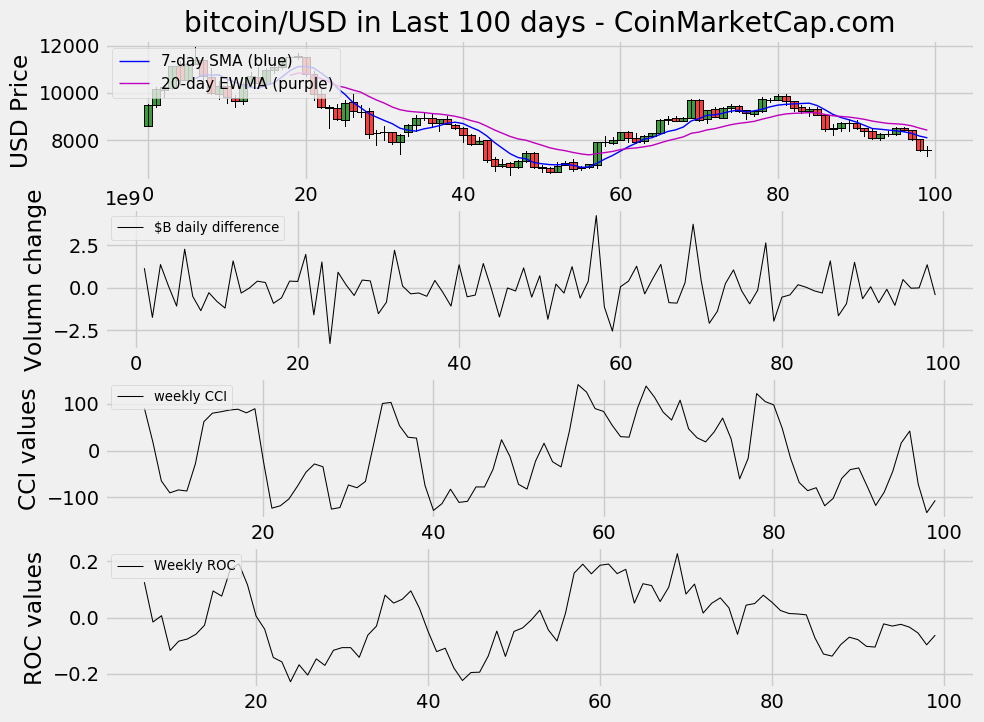

In [154]:
def CCI(histdata, ndays): 
     TP = (histdata['High'] +histdata['Low'] + histdata['Close']) / 3 
     #The index is scaled by an inverse factor of 0.015 to provide for more readable numbers.
     C = pd.Series((TP - pd.rolling_mean(TP, ndays)) / (0.015 * pd.rolling_std(TP, ndays)), name = 'CCI') 
     histdata = histdata.join(C) 
     return histdata


# Simple Moving Average 
def SMA(histdata, ndays): 
     SMA = pd.Series(pd.rolling_mean(histdata['Close'], ndays), name = 'SMA_'+ str(ndays)) 
     histdata = histdata.join(SMA) 
     return histdata


# Exponentially-weighted Moving Average 
def EWMA(histdata, ndays): 
     EMA = pd.Series(pd.ewma(histdata['Close'], span = ndays, min_periods = ndays - 1), 
     name = 'EWMA_' + str(ndays)) 
     histdata = histdata.join(EMA) 
     return histdata
 
    
#ROC = [(histdata['Close']- histdata['Close'].shift(-7)) / histdata['Close'].shift(-7)]
#exmpale use 7 days period Rate of change 
def ROC(histdata,n):
     N = histdata['Close'].diff(n)
     D = histdata['Close'].shift(n)
     ROC = pd.Series(N/D,name='Rate of Change')
     histdata = histdata.join(ROC)
     return histdata




    
#his100chart(company) perform data visulatizations for last 100 days trading data
def his100chart(company,numdays):
    company=company.lower()
    histdata=historyprice(company,numdays)
    histdata.reset_index(inplace=True)

    #show 20 day moving averages
    #print("Last 100-day trade history chart")
    vdiff=histdata['Volume'].diff(1)
    
    # Compute the 7-day SMA
    SMAdf= SMA(histdata,7)
    SMAdf= SMAdf.dropna()
    SMAdata = SMAdf['SMA_7']
    
    
    # Compute the 20-day EWMA 
    EWMAdf= EWMA(histdata,20)
    EWMAdf= EWMAdf.dropna()
    EWMAdata = EWMAdf['EWMA_20']

    CCIdf = CCI(histdata, 7)
    CCIdata = CCIdf['CCI']
    
    ROCdf = ROC(histdata,7)
    ROCdata= ROCdf['Rate of Change']
    
    
    
    fig= plt.figure(figsize=(10,8))
    ax = fig.add_subplot(4, 1, 1)
    plt.ylabel("USD Price")
    plt.title(company+"/USD "+"in Last "+ str(numdays)+" days - CoinMarketCap.com")
    candlestick2_ohlc(ax, histdata["Open"], histdata["High"], histdata["Low"], histdata["Close"], width=1, colorup='g')
    
    plt.plot(SMAdata,'b',lw=1, label='7-day SMA (blue)')
    plt.plot(EWMAdata,'m', lw=1, label='20-day EWMA (purple)')
    plt.legend(loc=2,prop={'size':11})
    plt.grid(True)
    print("")
    print("")
    
    bx = fig.add_subplot(4, 1, 2)
    plt.plot(vdiff,'k',lw=0.75,linestyle='-',label='$B daily difference')
    plt.legend(loc=2,prop={'size':9.5})
    plt.ylabel('Volumn change')
    plt.grid(True)
    print("")
    
    cx = fig.add_subplot(4, 1, 3)
    plt.plot(CCIdata,'k',lw=0.75,linestyle='-',label='weekly CCI')
    plt.legend(loc=2,prop={'size':9.5})
    plt.ylabel('CCI values')
    plt.grid(True)
    print("")
    
    dx = fig.add_subplot(4, 1, 4)
    plt.plot(ROCdata,'k',lw=0.75,linestyle='-',label='Weekly ROC')
    plt.legend(loc=2,prop={'size':9.5})
    plt.ylabel('ROC values')
    plt.grid(True)    
        
    plt.show()
 
his100chart("bitcoin",100) 

Form bitcoin chart, the 7-day EMA and 20-day EWMA are higher than the price, and market is starting to get some buying signal. Volumn change and ROC value are still negative because they are effectived by previous large volume sell. CCI is lower than 100 giving over sell level.

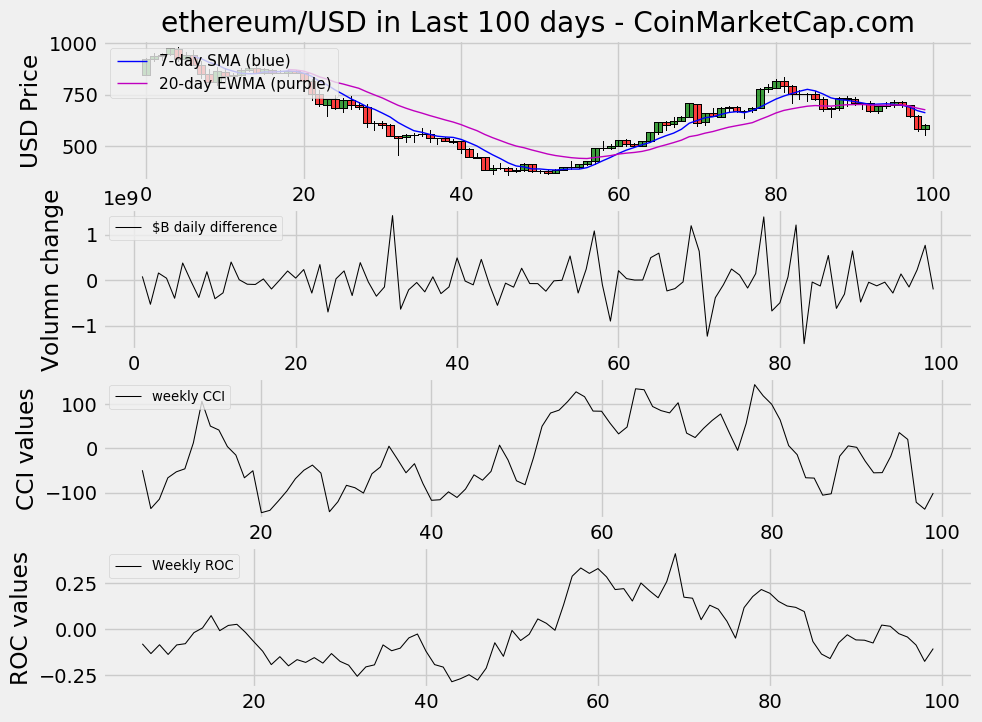

In [155]:
his100chart("ethereum",100) 

Form Ethereum chart, the 7-day EMA and 20-day EWMA are higher than the price, and market is starting to get some buying signal. Volume change and ROC value are still negative because they are effective by previous large volume sell. CCI is lower than 100 giving over sell level.  The reason of similarity for bitcoin and Ethereum is bitcoin always leading the coin market movement, even though Ethereum is second major coins in the coin market trading.

#### Arbitrage from instance marketing trade

Inspiring by economic marketing trading theorems, we observed arbitrage from three trade markets "USDT-BTC", "USDT-ETH" and "BTC-ETH". The data gets from bittrex.com last 100 buys and sell records.

In [157]:
#last100trade(symbol) will excutive after the trade confirmed
#return an array[ask, bid] to Trade() for order calculation 
def last100trade(symbol):
        #ticker="USDT-"+symbol
        url="https://bittrex.com/api/v1.1/public/getorderbook?market="+symbol+"&type=both"
        jdata=requests.get(url).json()
        if not bool(jdata):
            print("product is not exist!")
            return 
        else:
        #"sell" in API reflex to ask price
            ask=jdata["result"]["sell"]
            ask=pd.DataFrame(ask)
            ask.rename(columns={'Quantity':symbol+'.askV', 'Rate':symbol+'.askP'}, inplace=True)
            
            
            #"buy" in API reflex to bid price
            bid=jdata["result"]["buy"]
            bid=pd.DataFrame(bid)
            bid.rename(columns={'Quantity':symbol+'.bidV', 'Rate':symbol+'.bidP'}, inplace=True)
    
            lastprice=pd.concat([ask, bid], axis=1)
        
            lastprice = lastprice.sort_index(ascending=False)
            return(lastprice)

last100tradedata1=last100trade("USDT-BTC")
last100tradedata1.tail()

,USDT-BTC.askV,USDT-BTC.askP,USDT-BTC.bidV,USDT-BTC.bidP
4,4.050281,7429.450000,0.480870,7360.558
3,0.738900,7429.450000,0.003000,7373.450
2,0.474233,7428.749021,0.192283,7374.100
1,0.765300,7428.749021,0.465751,7374.100
0,0.064405,7428.749021,0.006835,7374.110


In [158]:
last100tradedata2=last100trade("USDT-ETH")
last100tradedata2.tail()

,USDT-ETH.askV,USDT-ETH.askP,USDT-ETH.bidV,USDT-ETH.bidP
4,8.586000,581.350000,0.217056,576.813776
3,0.040000,581.340000,0.007127,577.000000
2,4.645455,581.340000,0.040000,578.020000
1,9.267779,580.511052,0.100630,579.000000
0,24.000000,580.511052,0.413988,579.020006


In [159]:
last100tradedata3=last100trade("BTC-ETH")
last100tradedata3.tail()

,BTC-ETH.askV,BTC-ETH.askP,BTC-ETH.bidV,BTC-ETH.bidP
4,4.645455,0.078540,5.172429,0.078050
3,0.200000,0.078500,1.186189,0.078050
2,2.469528,0.078400,2.763983,0.078051
1,0.611855,0.078295,0.043964,0.078092
0,2.765958,0.078200,0.040000,0.078100


We created two stretegies with same logic that comparing original investment amount of USD after we long and short different coins in the real market, calculating the profit and loss for each transation.

Method 1: Assume I have amount of USD to buy 1 BTC (original investment), then I buy bitcoin, then short bitcoin and long ethereum, then sell ethereum to get USD.

Method 2: Assume I have amount of USD to buy 1 BTC (original investment), then I buy bitcoin, then short bitcoin and long ethereum, then sell ethereum to get USD.

In [160]:
def last100tradeprofit(symbol1,symbol2,symbol3 ):
    #symbol=symbol.upper()
    lasttrade1=last100trade(symbol1)
    lasttrade2=last100trade(symbol2)
    lasttrade3=last100trade(symbol3)
    lasttrade=pd.concat([lasttrade1, lasttrade2], axis=1)
    lasttrade=pd.concat([lasttrade, lasttrade3], axis=1)

    lasttrade= lasttrade.reset_index(drop=True)
    lasttrade.round(5).astype(Decimal)
    lasttrade.reset_index(inplace=True)
    
    #Assume I have amount of USD to buy 1 BTC (original investment), then I buy bitcoin
    lasttrade['method1Profit']=1/lasttrade['BTC-ETH.bidP']*lasttrade['USDT-ETH.bidP']-lasttrade['USDT-BTC.askP']
    lasttrade['method1Profit'].round(5).astype(Decimal)
    
    #Assume I have amount of USD to buy 1 BTC (original investment), then I buy ETH
    lasttrade['method2Profit']=lasttrade['USDT-BTC.askP']/lasttrade['USDT-ETH.bidP']*lasttrade['BTC-ETH.askP']*lasttrade['USDT-BTC.bidP']-lasttrade['USDT-BTC.bidP']
    lasttrade['method2Profit'].round(5).astype(Decimal)
    
    df=lasttrade.filter(['method1Profit','method2Profit'], axis=1)
    return df
    
last100tradeprofitdf=last100tradeprofit("USDT-BTC", "USDT-ETH", "BTC-ETH")
print(last100tradeprofitdf)

    method1Profit  method2Profit
0     -523.899381     857.907624
1     -516.225648     844.722777
2     -502.060939     825.262435
3     -498.537727     818.748004
4     -489.361880     808.185129
5     -477.460978     787.836874
6     -474.202354     780.360232
7     -470.399013     774.319823
8     -462.185290     764.804320
9     -460.587702     758.992199
10    -453.456072     748.681515
11    -452.541792     742.991893
12    -450.808348     736.466212
13    -447.802216     732.267677
14    -443.178185     725.985664
15    -436.252577     714.882657
16    -435.071323     711.038407
17    -423.979532     698.434671
18    -418.895724     689.734557
19    -405.517125     673.367760
20    -400.298094     667.492176
21    -383.756589     646.922247
22    -381.127862     641.391927
23    -371.088982     629.191217
24    -366.830749     617.996024
25    -363.359191     609.642494
26    -358.507620     603.834220
27    -358.249975     602.616448
28    -345.792071     587.831210
29    -342

Since the profit is not equal to zero, arbitrage is existing. Two opposite strategies give positive and negative results, which make sense for marketing trading. And both trends to zero as no arbitrage has zero profit and loss.

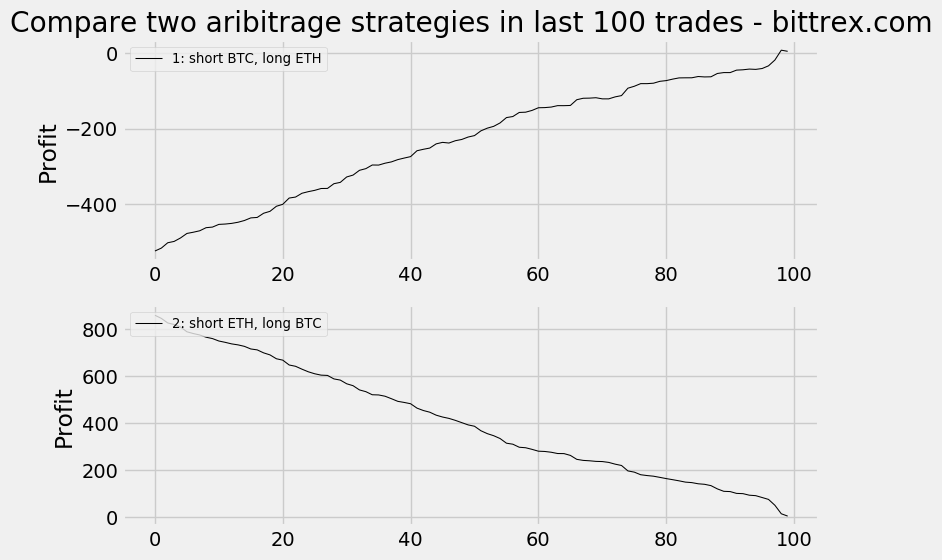

In [161]:
def last100tradeprofitchart(last100tradeprofitdf):
    
    fig= plt.figure(figsize=(8,6))
    ax = fig.add_subplot(2, 1, 1)
    plt.title("Compare two aribitrage strategies in last 100 trades - bittrex.com")
    plt.plot(last100tradeprofitdf['method1Profit'],'k',lw=0.75,linestyle='-',label='1: short BTC, long ETH')
    plt.legend(loc=2,prop={'size':9.5})
    plt.ylabel('Profit')
    plt.grid(True)
  
    bx = fig.add_subplot(2, 1, 2)
    plt.plot(last100tradeprofitdf['method2Profit'],'k',lw=0.75,linestyle='-',label='2: short ETH, long BTC')
    plt.legend(loc=2,prop={'size':9.5})
    plt.ylabel('Profit')
    plt.grid(True)
    plt.show()


last100tradeprofitchart(last100tradeprofitdf)

From the chart, these two strategies give an opposite ways direction and showing the profit and loss trends to die out at close time. It represents the market profit will disperse soon after speculators found out.

Pros: The analysis using last 100 days gives a sign for instant coin market speculators to investing in short-term. Last 100 trading for arbitrage gives an accuracy of the investment direction.

Cons: The data resource is limited to public uses. The last 100 trades for buy and sell don't have a timestamp, the movement for observing the behavior of speculator is lack of accuracy.

## Bitcoin Option Price Prediction

The Deribit exchange is the only major exchange with cryto options available.  Currently, only Bitcoin options are available and the trading volume is relatively small.  As such, the market seems primed to be exploited with a simple strategy.  The Black Scholes model became the gold standard for fair option pricing several decades ago.  A price prediction model built around the Black Scholes framework should be able to defeat this market.

### Load Data

In [59]:
def get_train_data():
    from pymongo import MongoClient
    import pandas as pd

    connection = MongoClient('ds149279.mlab.com', 49279)
    db = connection['data602final']
    db.authenticate('me', 'mypass')
    
    df = pd.DataFrame([item for item in db.btc_options.find({})])
    sds = pd.DataFrame([item for item in db.sds.find({})])
    return df, sds
df, sds = get_train_data()

### Data Munging

We load two key functions, one that returns how far out of the money the option is, and one that returns the predicted Black Scholes price.  One of the key violations of Black Scholes is the volatility smile.  If one were to plot strike price against implied volatility, an unmodified Black Scholes model would assume a straight line.  Implied volatility would be constant.  However in practice it is either downward sloping or curved, hence the name.

In [60]:
def strike_dist(df):
    if df.option_type == 'C':
        return (df.indexPrice - df.strike)/df.strike
    else:
        return (df.strike - df.indexPrice)/df.strike
    
def black_scholes(df, option_type):
    from scipy.stats import norm
    import numpy as np
    
    current = df.indexPrice.values
    rf = df['rf'].values
    t = (df.expiration_date.values - df.timeStamp.values).astype('timedelta64[s]').astype(float)/(365*86400)
    top_d1 = np.log(current/df.strike.values) + (rf + ((df.sd.values)**2)/2)*t
    bottom_d1 = df.sd.values*np.sqrt(t)
    d1 = top_d1/bottom_d1

    d2 = d1 - df.sd.values*np.sqrt(t)
    if option_type == 'C':
        return current*norm.cdf(d1) - df.strike.values*np.exp(-rf*t)*norm.cdf(d2)
    else:
        return df.strike.values*np.exp(-rf*t)*norm.cdf(-d2) - current*norm.cdf(-d1)

We must also created the other features, cumulative volume, and option type.  The response variable is an adjusted option price two trades in the future.  Two trades was chosen to allow the price some time to correct to fair value if it was mispriced.  The actual response variable is: (current price - future price) - (current BS predicted price - future BS predicted price).  This net change will largely keep the response variable independent of changes in the price of the underlying, Bitcoin.

In [61]:
def prep_data(sds, df):
    import pandas as pd
    from datetime import datetime, timedelta
    from quandl import get

    

    warnings.filterwarnings('ignore')
    get_date = lambda x: datetime.strptime(x, '%d%b%y')
    
    get_cols = lambda x: pd.Series([item for item in x.split('-')])
    cols = df['instrument'].apply(get_cols)
    cols.columns = ['uderlying', 'expiration_date', 'strike', 'option_type']
    df = pd.concat([df, cols], axis = 1)
    df.loc[:, 'expiration_date'] = df['expiration_date'].map(get_date)
    add_time = lambda x: timedelta(days = 1) - timedelta(seconds = 1) + x #make exp date end of day
    df['expiration_date'] = df['expiration_date'].map(add_time)
    
    df = df.dropna()
    df['strike'] = df['strike'].map(int)
    df['timeStamp'] = df['timeStamp'].map(lambda x: datetime.fromtimestamp(x/1000))
    df['time_left'] = (df['expiration_date'] - 
      df['timeStamp']).values.astype('timedelta64[s]').astype(float)/(365*86400)
    df['date'] = df['timeStamp'].map(lambda x: x.date())
    sds['date'] = sds['date'].map(lambda x: x.date())
    rf = get('FRED/DTB6', start_date = '2016-01-01')/100
    rf.loc[:, 'date'] = rf.index.values
    rf['date'] = rf['date'].map(lambda x: x.date())
    rf.rename(columns = {'Value': 'rf'}, inplace = True)
    
    
    df = pd.merge(df, sds, on = ['date'])
    df = pd.merge(df, rf, on = ['date'])
    
    
    calls = df.loc[df.option_type == 'C']
    puts = df.loc[df.option_type == 'P']
    
        
    call_prices = black_scholes(calls, 'C')
    put_prices = black_scholes(puts, 'P')
    calls.loc[:, 'bs_price'] = call_prices
    puts.loc[:, 'bs_price'] = put_prices
    
    df2 = pd.concat([calls, puts], axis = 0)
    
    
        
    df2['strike_dist'] = df2.apply(strike_dist, axis = 1)
    
    df2['price'] = df2.apply(lambda x: x.price * x.indexPrice, axis = 1)#option price converted to USD
    df2['price_delta'] = df2.apply(lambda x: 
        min(max((x.bs_price - x.price)/x.price, -2), 2), axis = 1)#difference between option price and
    #price predicted by BS formula
    
    df2.sort_values(['instrument', 'tradeSeq'], inplace = True)
    grouped = df2.groupby(['instrument'])['quantity'].cumsum()
    df2.loc[:, 'cum_volume'] = grouped
    df2.sort_values(['instrument', 'tradeSeq'], ascending  = False, inplace = True)
    
    #this operation should be a function for style
    #get the price 2 trades in the future.  We can play around with this number
    df2.loc[:,'fut_option_price'] = df2.groupby(['instrument']).price.shift(2)
    df2.loc[:,'fut_und_price'] = df2.groupby(['instrument']).indexPrice.shift(2)
    df2.loc[:,'fut_bs_price'] = df2.groupby(['instrument']).bs_price.shift(2)
    df2['price_change'] = (df2.fut_option_price - df2.price)/df2.price
    df2['index_change'] = df2.fut_und_price - df2.indexPrice
    df2['net_change'] = df2.apply(
            lambda x: min(max(x.price_change - (x.fut_bs_price - x.bs_price)/x.bs_price, -2), 2), axis = 1)
    
    #I'm still not 100% sure net_change is the value we want to predict.  Here's my thinking:
    #The idea is that we want measure of price change
    #that is independent of price changes in the underlying.  With net change, if the underlying didn't change,
    #future_bs_price - bs_price should be zero, so we're left with the price change.  For a call, if the underlying
    #goes up, the fut_bs_price - bs_price will be positive, and should offset the part of the price change due to
    #a change in price in the underlying.  What you're left with is any change in price due to the option valuation
    #getting closer to a fair value
    
    opt_map = {'C': 1, 'P': 2}
    
    
    df2['option_type'] = df2['option_type'].map(lambda x: opt_map[x])
    X = df2.loc[df2['fut_option_price'].notna(), ['cum_volume', 'strike_dist', 'price_delta', 'time_left', 'option_type']]
    
    Y = df2.loc[df2['fut_option_price'].notna(), ['net_change']]
    return (X, Y, df2)
X, Y, df2 = prep_data(sds, df)
actuals = df2.loc[df2['fut_option_price'].notna(), ['price_change']].values
groups = df2.loc[df2['fut_option_price'].notna(), ['instrument']]

In [62]:
df2.head()

,_id_x,direction,indexPrice,instrument,iv,price,quantity,tickDirection,timeStamp,tradeId,...,bs_price,strike_dist,price_delta,cum_volume,fut_option_price,fut_und_price,fut_bs_price,price_change,index_change,net_change
6614,5ad6849305a44a074c575b69,buy,8411.90,BTC-9MAR18-9500-P,0.00,1082.611530,0.1,2,2018-03-09 01:03:59.185,5443698,...,1090.831531,0.114537,0.007593,9.7,NaN,NaN,NaN,NaN,NaN,NaN
6615,5ad6849305a44a074c575b6a,buy,8468.30,BTC-9MAR18-9500-P,500.00,1142.373670,0.2,0,2018-03-09 00:52:38.980,5442907,...,1035.747208,0.108600,-0.093338,9.6,NaN,NaN,NaN,NaN,NaN,NaN
6616,5ad6849305a44a074c575b6b,buy,8490.05,BTC-9MAR18-9500-P,500.00,1133.421675,0.3,0,2018-03-09 00:52:17.622,5442878,...,1014.571684,0.106311,-0.104859,9.4,1082.611530,8411.90,1090.831531,-0.044829,-78.15,-0.119994
6617,5ad6849305a44a074c575b6c,sell,8516.07,BTC-9MAR18-9500-P,500.00,1051.734645,0.1,0,2018-03-09 00:51:00.046,5442664,...,989.331358,0.103572,-0.059334,9.1,1142.373670,8468.30,1035.747208,0.086181,-47.77,0.039264
7277,5ad6849305a44a074c575b6d,buy,9033.19,BTC-9MAR18-9500-P,287.22,553.734547,0.2,2,2018-03-08 21:55:44.179,5435525,...,531.509037,0.049138,-0.040137,9.0,1133.421675,8490.05,1014.571684,1.046868,-543.14,0.138017


### Model Building

With our features in place, we want to try several models and see which of them perform the best.  We'll train both regressors and classifiers with the intention of using both to make our trade decisions.

First we optimize hyperparameter selection based of the F measure. (This code is not run here, as it takes over an hour)

In [ ]:
param_grid = {'min_samples_leaf': [2, 5, 10],
          'min_samples_split': [2, 5, 10],
          'max_depth' : [2, 3],
          'subsample': [.8, 1],
          'max_features' : [.8, 1]
          }

y_fit = (Y.values > 0)*1
gb = GridSearchCV(GradientBoostingClassifier(n_estimators = 700), param_grid, make_scorer(f1_score),
                  cv = rs)
gb.fit(X, y_fit.ravel())
print(gb.best_estimator_)

param_grid = {'min_samples_leaf': [2, 5, 10],
          'min_samples_split': [2, 5, 10],
          'max_depth' : [2, 3],
          'max_features' : [.8, 1]
          }

y_fit = (Y.values > 0)*1
rf = GridSearchCV(RandomForestClassifier(n_estimators = 200), param_grid, make_scorer(f1_score),
                  cv = rs)
rf.fit(X, y_fit.ravel())
print(rf.best_estimator_)

We employ a 10 fold cross validation and return some metrics for each fold to determine the best model.

In [115]:
warnings.filterwarnings('ignore')
all_mets = []
rs  = KFold(n_splits=10, shuffle=True)
splits = rs.split(X, Y, groups = groups)
for train, test in splits:
    x_train, y_train = X.iloc[train,:], Y.iloc[train,:]
    x_test, y_test_adj, y_test = X.iloc[test, :],  Y.iloc[test,:].values, actuals[test] 

    logistic_test = (y_test > 0)*1
    logistic_adj = (y_test_adj > 0)*1
    logistic_train = (y_train.values > 0)*1
    #gb classifier
    gb = ske.GradientBoostingClassifier(min_samples_leaf= 5,
          min_samples_split= 10,
          max_depth = 3,
          subsample = .8,
          n_estimators = 1000)    
    gb.fit(x_train, logistic_train.ravel())
    probs3 = gb.predict_proba(x_test)
    
    fpr_gb, tpr_gb, _ = roc_curve(logistic_test, probs3[:,1].ravel(), 1)
    fpr_gb_adj, tpr_gb_adj, _ = roc_curve(logistic_adj, probs3[:,1].ravel(), 1)

    
    #rf classifier
    regr = ske.RandomForestClassifier(min_samples_leaf = 10, n_estimators = 100, min_samples_split = 10)
    regr.fit(x_train, logistic_train.ravel())
    probs2 = regr.predict_proba(x_test)
    fpr_rf, tpr_rf, _ = roc_curve(logistic_test, probs2[:,1].ravel(), 1)
    fpr_rf_adj, tpr_rf_adj, _ = roc_curve(logistic_adj, probs2[:,1].ravel(), 1)
    #pred = regr.predict(x_test)
    
    
    #logistic classifier on original data
    log_regr = LogisticRegression()
    log_regr.fit(x_train, logistic_train.ravel())
    probs1 = log_regr.predict_proba(x_test)
    fpr_log, tpr_log, _ = roc_curve(logistic_test, probs1[:,1].ravel(), 1) 
    fpr_log_adj, tpr_log_adj, _ = roc_curve(logistic_adj, probs1[:,1].ravel(), 1) 


    #stack
    all_probs = np.array([probs2[:,1].ravel(), probs3[:,1].ravel()]).mean(axis = 0)
    fpr_st, tpr_st, _ = roc_curve(logistic_test, all_probs.ravel(), 1)
    fpr_st_adj, tpr_st_adj, _ = roc_curve(logistic_adj, all_probs.ravel(), 1)
    

    #Regressors
    #gb
    gb_reg = ske.GradientBoostingRegressor(n_estimators = 1000, 
                                      min_samples_leaf = 5, 
                                      min_samples_split = 10, 
                                      max_depth = 3
                                      )
    gb_reg.fit(x_train, y_train.values.ravel())
    
    pred1 = gb_reg.predict(x_test) 
    
    rf_reg = ske.GradientBoostingRegressor(n_estimators = 200, 
                                       min_samples_leaf = 5, 
                                       min_samples_split = 10, 
                                       max_depth = 3
                                       )
    rf_reg.fit(x_train, y_train.values.ravel())
    pred2 = rf_reg.predict(x_test) 
    #stack
    pred3 = np.array([pred1, pred2]).mean(axis = 0)

    
    #mets
    mets = { 
                'price_increase_rf': np.percentile(y_test[(probs2[:,1] > .65) & (pred1 > .05)], 50),
                'price_increase_gb': np.percentile(y_test[(probs3[:,1] > .65) & (pred2 > .05)], 50),
                'price_increase_log' : np.percentile(y_test[probs1[:,1] > .6], 50),
                'price_increase_st' : np.percentile(y_test[(all_probs > .65) & (pred3 > .05)], 50),
                'pirce_increase_median' : np.percentile(y_test, 50),
                'price_increase_rfm': y_test[(probs2[:,1] > .65) & (pred1 > .05)].mean(),
                'price_increase_gbm': y_test[(probs3[:,1] > .65) & (pred2 > .05)].mean(),
                'price_increase_stm' : y_test[(all_probs > .65) & (pred3 > .05)].mean(),
                'pirce_increase_mean' : y_test.mean(),
                'score_gb' : gb.score(x_test, logistic_test),
                'score_rf' : regr.score(x_test, logistic_test),
                'score_log' : log_regr.score(x_test, logistic_test),
                'mse_gb' : mean_squared_error(y_test, pred1),
                'mse_rf' : mean_squared_error(y_test, pred2),
                'mse_st' : mean_squared_error(y_test, pred3),
                'r2_gb' :  r2_score(y_test, pred1),
                'r2_rf' :  r2_score(y_test, pred2),
                'r2_st' :  r2_score(y_test, pred3),
                'auc_rf' : auc(fpr_rf, tpr_rf),
                'auc_gb' : auc(fpr_gb, tpr_gb),
                'auc_st' : auc(fpr_st, tpr_st)
            }
    all_mets.append(mets)
met_df = pd.DataFrame(all_mets)


Feature importances are very similar between the two best candidates

In [126]:
dict(zip(['cum_volume', 'strike_dist', 'price_delta', 'time_left', 'option_type'], regr.feature_importances_))

{'cum_volume': 0.20397203898866903,
 'option_type': 0.01599299681945984,
 'price_delta': 0.27742773732055354,
 'strike_dist': 0.25186749270659325,
 'time_left': 0.2507397341647242}

In [127]:
dict(zip(['cum_volume', 'strike_dist', 'price_delta', 'time_left', 'option_type'], gb.feature_importances_))

{'cum_volume': 0.1620849376306928,
 'option_type': 0.011575490286878569,
 'price_delta': 0.2395139605040643,
 'strike_dist': 0.26969246211287845,
 'time_left': 0.31713314946548565}

First we use the adjusted values to asses the pure model quality using net net change.  This should show the nuance between the models that is not lost in random price variations on the underlying.  This will make the models appear much better than they are, so we will show the unadjusted values next.

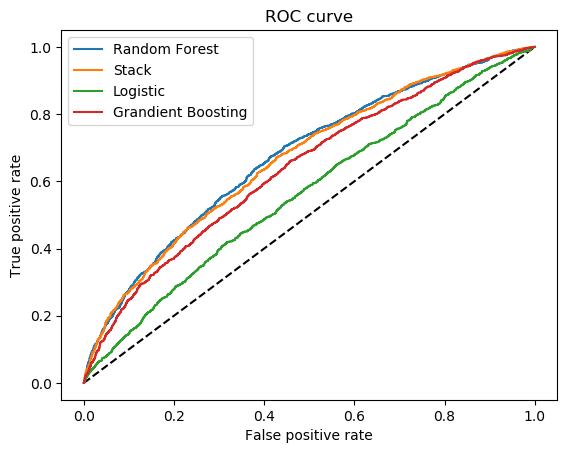

In [116]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf_adj, tpr_rf_adj, label='Random Forest')
plt.plot(fpr_st_adj, tpr_st_adj, label='Stack')
plt.plot(fpr_log_adj, tpr_log_adj, label='Logistic')
plt.plot(fpr_gb_adj, tpr_gb_adj, label='Grandient Boosting')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

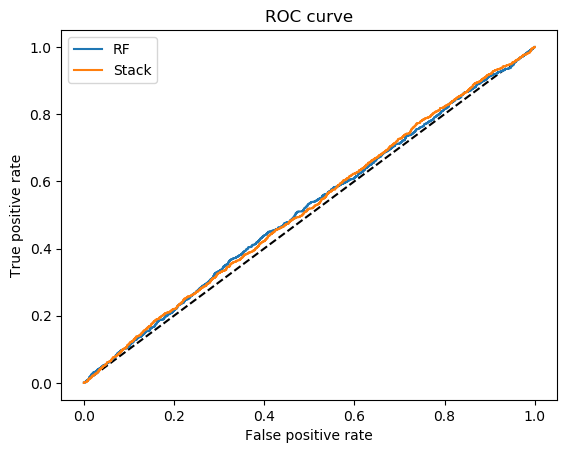

In [134]:
plt.style.use('default')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_st, tpr_st, label='Stack')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [118]:
met_df

,auc_gb,auc_rf,auc_st,mse_gb,mse_rf,mse_st,pirce_increase_mean,pirce_increase_median,price_increase_gb,price_increase_gbm,...,price_increase_rf,price_increase_rfm,price_increase_st,price_increase_stm,r2_gb,r2_rf,r2_st,score_gb,score_log,score_rf
0,0.523083,0.526649,0.526653,989.519684,989.611894,989.564392,0.621530,6.165236e-07,0.000258,5.243200,...,0.016909,4.840445,0.006500,5.103411,0.001314,0.001221,0.001269,0.509772,0.506282,0.511633
1,0.533795,0.545411,0.542216,2.387885,2.398629,2.391739,0.127842,0.000000e+00,0.001767,0.705918,...,0.006050,0.651990,0.007610,0.635775,0.026278,0.021897,0.024706,0.517915,0.497208,0.526059
2,0.521516,0.529798,0.527060,1039.116555,1039.384165,1039.248861,0.635056,0.000000e+00,0.001469,5.280185,...,0.002883,4.625239,0.004101,5.044738,0.000834,0.000577,0.000707,0.520009,0.493951,0.520475
3,0.491198,0.503961,0.498280,982.399716,982.249522,982.322870,0.531137,-6.955788e-05,0.000000,4.629473,...,0.000292,4.478174,0.000262,4.823769,0.000755,0.000908,0.000834,0.485342,0.479060,0.493020
4,0.527299,0.539372,0.536317,116.407189,116.445994,116.425081,0.354185,0.000000e+00,0.007501,3.066771,...,0.005728,2.575503,0.004230,2.727565,0.002523,0.002190,0.002369,0.515356,0.491857,0.526524
5,0.522102,0.527629,0.526675,105.811573,105.856228,105.832189,0.300208,0.000000e+00,0.000312,2.413648,...,0.000351,2.223208,0.004111,2.256666,0.003955,0.003535,0.003761,0.511866,0.498837,0.520707
6,0.532849,0.534603,0.536558,993.080365,993.097915,993.087777,0.599701,-4.484787e-06,0.000184,5.049352,...,0.003352,4.432282,0.002855,4.664732,0.001039,0.001022,0.001032,0.519311,0.486971,0.518846
7,0.518225,0.529828,0.525533,1537.016105,1537.095270,1537.053919,0.714552,0.000000e+00,0.000064,5.832891,...,0.012461,5.829508,0.005726,5.709330,0.000645,0.000593,0.000620,0.509307,0.489065,0.516054
8,0.518333,0.527846,0.524086,5.439714,5.458969,5.447630,0.132177,2.560597e-06,0.004482,0.802886,...,0.012784,0.736506,0.018612,0.822936,0.021836,0.018374,0.020413,0.511520,0.494298,0.522458
9,0.516835,0.517812,0.519078,219.365172,219.444879,219.403382,0.343480,0.000000e+00,0.000027,2.248786,...,0.000548,1.988983,0.000547,2.056089,0.001944,0.001581,0.001770,0.508727,0.497789,0.512218


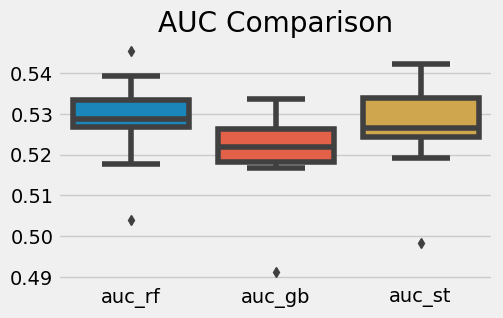

In [137]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(5,3))
sns.boxplot(data = met_df[['auc_rf', 'auc_gb', 'auc_st']])
plt.title('AUC Comparison')
plt.show()

If the Gradient Boosting performance can be improved, it looks like the best option will be a stack with Random Forest.  In future iterations, this will be attemped.

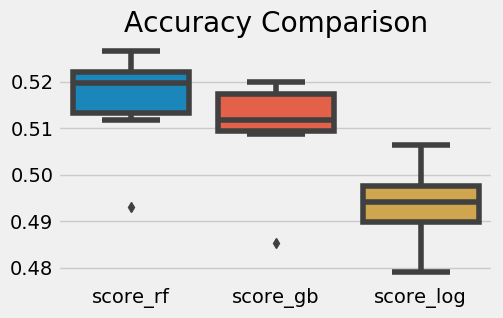

In [147]:
plt.figure(figsize=(5,3))
sns.boxplot(data = met_df[['score_rf', 'score_gb', 'score_log']])
plt.title('Accuracy Comparison')
plt.show()

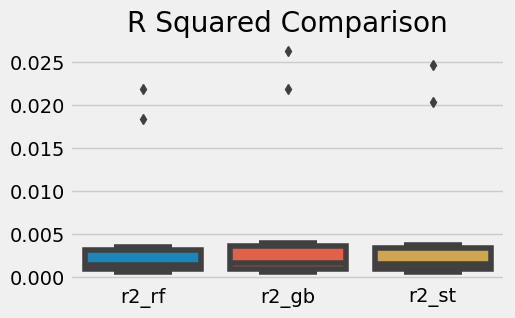

In [146]:
plt.figure(figsize=(5,3))
sns.boxplot(data = met_df[['r2_rf', 'r2_gb', 'r2_st']])
plt.title('R Squared Comparison')
plt.show()

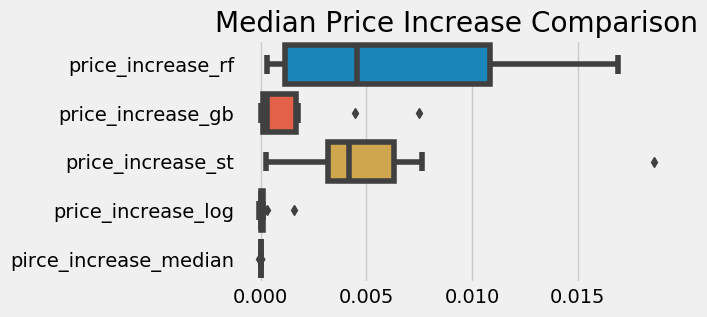

In [145]:
plt.figure(figsize=(5,3))
sns.boxplot(data = met_df[['price_increase_rf', 'price_increase_gb', 'price_increase_st', 'price_increase_log', 'pirce_increase_median']],
           orient = 'h')
plt.title('Median Price Increase Comparison')
plt.show()

The logistic regression found far fewer candidate options, so the its mean price increase was not compared.  The few options 
that increased over 100% would skew the result.

In [73]:
sum(probs1[:, 1] > .6)

272

In [74]:
sum((probs3[:,1] > .65) & (pred2 > .05))

512

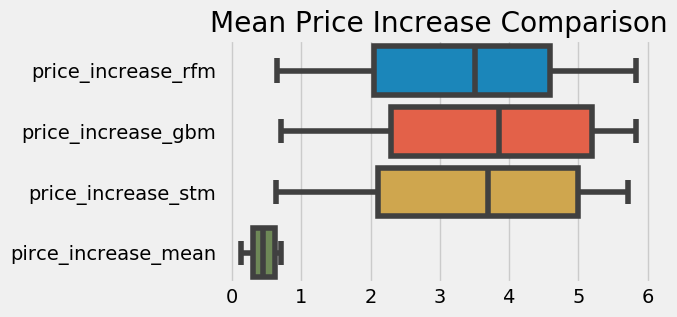

In [142]:
plt.figure(figsize=(5,3))
sns.boxplot(data = met_df[['price_increase_rfm', 'price_increase_gbm', 'price_increase_stm', 'pirce_increase_mean']], 
           orient = 'h')
plt.title('Mean Price Increase Comparison')
plt.show()

It looks as the the models performed nicely when the mean was considered.  This was because of huge gains from a few trades.

### Volatility Smile

Dealing with volatility smile will be one of the ways we can improve the model. We create functions to return the implied volatility of each option.

In [76]:
def impl_vol_func(vol, df):
    from scipy.stats import norm
    
    rf = df['rf']
    t = df['time_left']
    top_d1 = np.log( df.indexPrice/df.strike) + (rf + ((vol)**2)/2)*t
    bottom_d1 = vol * np.sqrt(t)
    d1 = top_d1/bottom_d1

    d2 = d1 - vol * np.sqrt(t)
    if df.option_type == 'C':
        return  df.price - (df.indexPrice*norm.cdf(d1) - df.strike * np.exp(-rf*t) * norm.cdf(d2))
    else:
        return df.price - (df.strike * np.exp(-rf * t) * norm.cdf(-d2) - df.indexPrice * norm.cdf(-d1))
def vega(vol, df):
    from scipy.stats import norm
    
    rf = df['rf']
    t = df['time_left']

    top_d1 = np.log(df.indexPrice/df.strike) + (rf + ((vol)**2)/2)*t
    bottom_d1 = vol * np.sqrt(t)
    d1 = top_d1/bottom_d1
    return df.indexPrice * np.sqrt(t) * norm.cdf(d1, 0.0, 1.0)

def get_implied_vol(df):
    from scipy.optimize import fsolve
    
    impl_vol = fsolve(impl_vol_func, df['sd'], args = (df,), fprime = vega)
    
    return impl_vol[0]

In [77]:
from datetime import datetime
this_year = df2.loc[df2['timeStamp'] >= datetime(2018,1,1)]

In [78]:
warnings.filterwarnings('ignore')
this_year['implied_vol'] = this_year.apply(get_implied_vol, axis = 1)

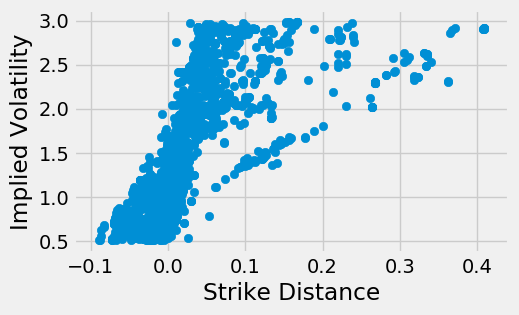

In [143]:
plt.figure(figsize=(5,3))
only_calls = this_year.loc[(this_year['implied_vol'] > .5) & (this_year['implied_vol'] < 3) & (this_year['option_type'] == 1)]
plt.scatter(only_calls['strike_dist'], only_calls['implied_vol'])
plt.xlabel('Strike Distance')
plt.ylabel('Implied Volatility')
plt.show()

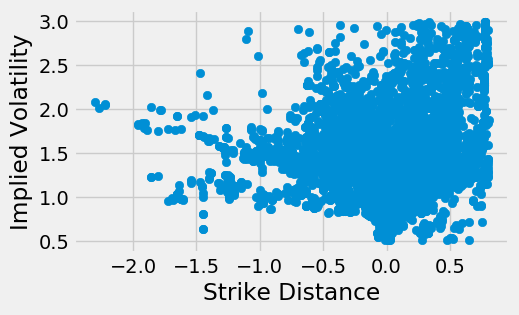

In [144]:
plt.figure(figsize=(5,3))
only_puts = this_year.loc[(this_year['implied_vol'] > .5) & (this_year['implied_vol'] < 3) & (this_year['option_type'] == 2)]
plt.scatter(only_puts['strike_dist'], only_puts['implied_vol'])
plt.xlabel('Strike Distance')
plt.ylabel('Implied Volatility')
plt.show()

The pattern was much more clear for calls than it was for puts.  It is unclear what that means for price predictions.  This is one of the future improvments that can be made to the model.

## Conclusion

Both models show promise for an algorithmic trading strategy.  The Black Scholes based model can be seen in action on aviable options in our Flask app.  To truly put it into production, the app would need to stream trades via a technology like websockets.  Additionally, because of the extreme volatility seen with Bitcoin in the past couple weeks it might be overly optimistic.